## Land Obstacle Notebook

### Overview
This notebook was used to explore how to import and work with bathymetric data from GEBCO. The cells implement a pipeline from raw netCDF data to the final product of a Land Obstacle.

Below is an image of the data selection area from the GEBCO website. In this notebook, we are working with a small set of data for the Salish Sea.

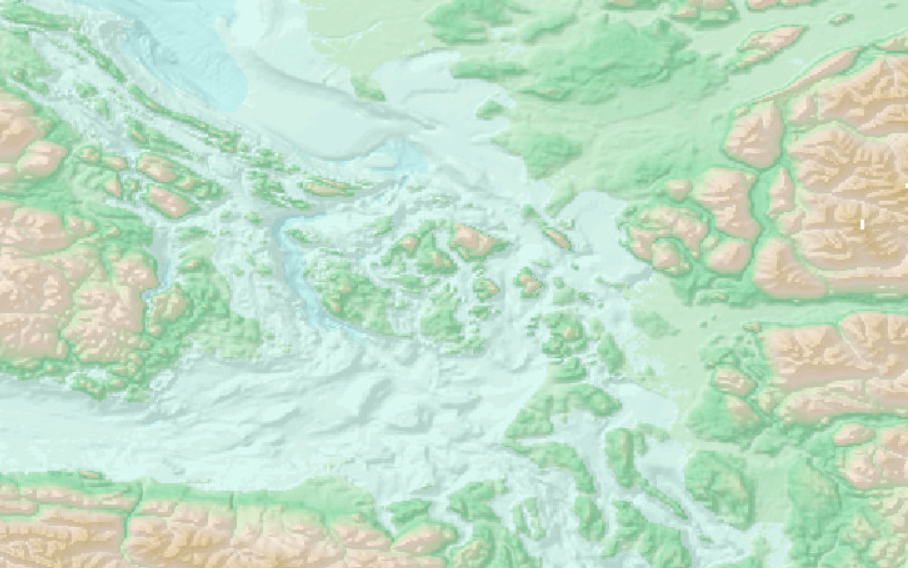

In production we will use a much larger data set from the selection shown below

\
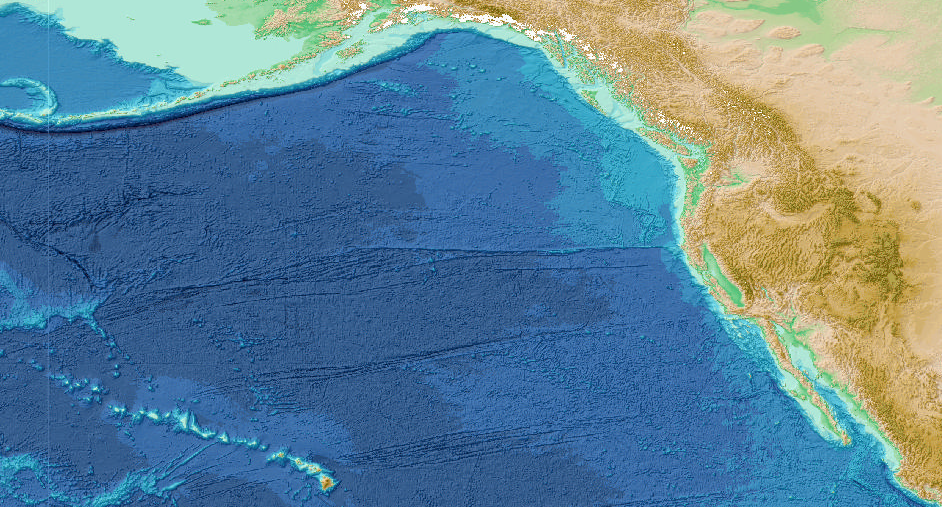

### Data Flow

Below is a diagram of the planned flow of data from raw bathymetric data to Land Obstacles.

**Note:** in this notebook, I skip converting latlon points to XY as that process requires coord_systems.py from local_pathfinding.\
In theory everything should still work fine, by leaving the points in LatLon form we are just working with an Equirectangular Projection,\
meaning we are treating latitude and longitude as 2D cartesian coordinates.

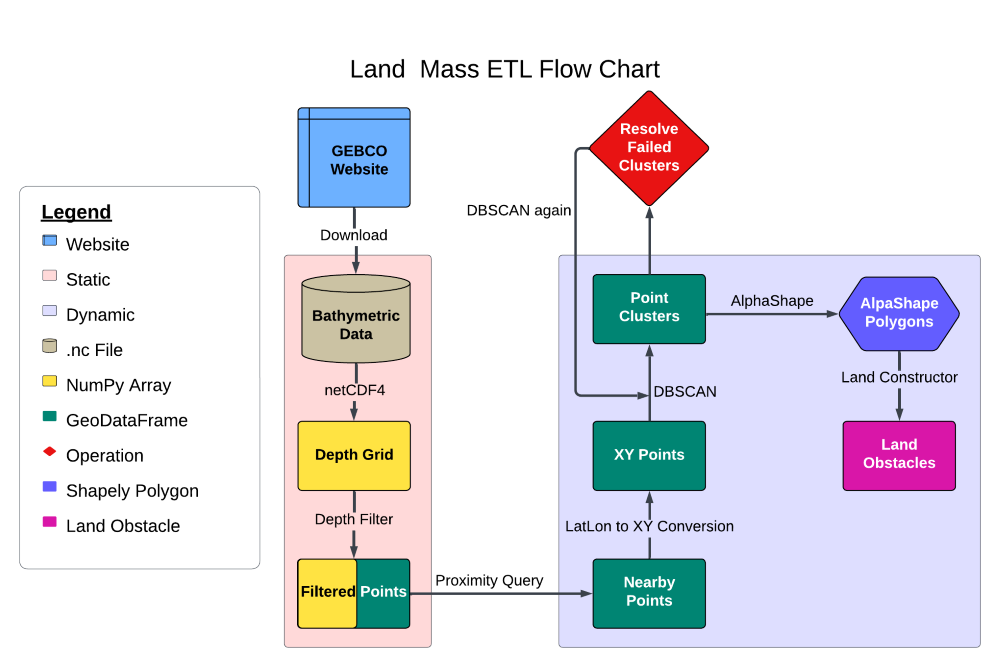

### Setup

In [3]:
!pip3 install shapely matplotlib netCDF4 numpy geopandas plotly scikit-learn alphashape pandas

Defaulting to user installation because normal site-packages is not writeable


In [4]:
from shapely.geometry import Point, MultiPoint, MultiPolygon, GeometryCollection
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import geopandas as gpd
from geopandas import GeoDataFrame
from typing import List
import plotly.graph_objects as go
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import alphashape
import pandas as pd
import timeit

# NETCDF_FILE = "/workspaces/sailbot_workspace/src/notebooks/local_pathfinding/netCDF/salish_sea.nc"
NETCDF_FILE = "/workspaces/sailbot_workspace/src/notebooks/local_pathfinding/netCDF/van.nc"
MIN_DEPTH = -20  # meters

## Data Structure

The first step in the netCDF -> Land Obstacle pipeline is to import the netCDF data into a data structure instance. \
The two options considered for the data structure are: 

* NumPy ndarray
* GeoPandas GeoDataFrame

The next few cells test out both options.

### Using NdArray

The cell below loads the netCDF data into a 3D ndarray. Each data point is an ndarray containing [latitude, longitude, elevation]


In [5]:
# Wrap ndarray loading in a function to test performance
def load_ndarray():
    with Dataset(NETCDF_FILE, "r") as data:

        lat = data.variables["lat"][:].data
        lon = data.variables["lon"][:].data
        elevation = data.variables["elevation"][:].data

    # create empty dpts_filtered_nparray to store all data points
    dpts = np.empty((len(elevation), len(elevation[0]), 3))

    # This is so much faster than the for loop below
    dpts[:, :, 0] = lat[:, None]
    dpts[:, :, 1] = lon[None, :]
    dpts[:, :, 2] = elevation

    """
    for i in range(len(elevation)):

        for j in range(len(elevation[0])):

            dpts[i][j] = np.array([lat[i], lon[j], elevation[i][j]])
    """

    return dpts


dpts = load_ndarray()

This is just a quick plot of a VERY small subset of the data, to see what it looks like in 3D

10000 10000 10000


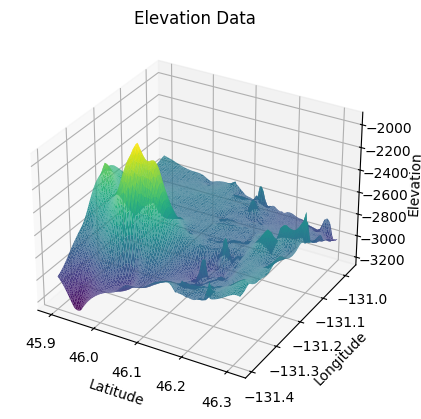

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Extract x, y, z coordinates from the dpts array
x = dpts[0:100, 0:100, 0].flatten()
y = dpts[0:100, 0:100, 1].flatten()
z = dpts[0:100, 0:100, 2].flatten()

print(len(x), len(y), len(z))

# Plot elevation data as a surface plot
ax.plot_trisurf(x, y, z, cmap="viridis")

# Set labels and title
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")
ax.set_zlabel("Elevation")
ax.set_title("Elevation Data")

# Show the plot
plt.show()

### Using GeoDataFrame

In [7]:
# Wrap dataframe loading in a function to test performance


def load_gdf():
    with Dataset(NETCDF_FILE, "r") as nc_dataset:

        # Extract latitude, longitude, and depth information
        latitude = nc_dataset.variables["lat"][:]
        longitude = nc_dataset.variables["lon"][:]
        depth = nc_dataset.variables["elevation"][:]

    # Create meshgrid of latitude and longitude
    lon_grid, lat_grid = np.meshgrid(longitude, latitude)

    # Flatten latitude, longitude, and depth arrays
    lat_flat = lat_grid.flatten()
    lon_flat = lon_grid.flatten()
    depth_flat = depth.flatten()

    # Create GeoDataFrame
    geometry = gpd.points_from_xy(lon_flat, lat_flat)

    gdf = GeoDataFrame(geometry=geometry, columns=["geometry"])

    # Add depth values as a new column
    gdf["depth"] = depth_flat

    return gdf


gdf = load_gdf()

In [8]:
# Plot UNFILTERED bathymetry using GeoPandas
# gdf.plot(column="depth", cmap="viridis", legend=True, vmin=MIN_DEPTH, vmax=0, markersize=0.1)

### Speed Comparison 
NumPy Array vs. GeoDataFrame

In [9]:
ndarray_time = timeit.timeit(load_ndarray, number=10)
gdf_time = timeit.timeit(load_gdf, number=10)

f"{ndarray_time=:.6f}s, {gdf_time=:.6f}s"

'ndarray_time=0.446428s, gdf_time=7.144601s'

### Conclusion
Loading the data into a NumPy array is considerably faster than loading it into a GeoDataFrame.
Storing the land data in a NumPy Array is the clear choice here.

However, later once the points have been filtered for depth, it will probably be nice to have them in a GeoDataFrame \
to make use of spatial indexing when we need to return all points in a certain area.

## Data Point Filtering

The next step is to filter the data to only include points above a certain depth. This is done by filtering out all points with an elevation of MIN_DEPTH or less.\
This can be done by boolean indexing.

In [10]:
# Filtering GeoDataFrame
# Filter out all points above min depth
# gdf_filtered is a new GeoDataFrame
gdf_filtered = gdf[gdf["depth"] >= MIN_DEPTH]

In [11]:
# Filtering the NumPy Array dpts by removing any points with depth < MIN_DEPTH
# this is now a 2D array ov remaining data points
dpts_filtered = dpts[dpts[:, :, 2] >= MIN_DEPTH]

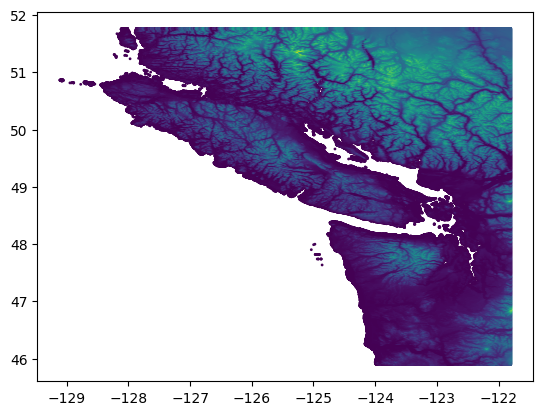

In [12]:
# Plot Filtered Bathymetry from NumPy Array

# plot dpts_filtered_nparr
lon = dpts_filtered[:, 1]
lat = dpts_filtered[:, 0]
elevation = dpts_filtered[:, 2]


# Plot elevation data
plt.scatter(lon, lat, c=elevation, cmap="viridis", s=1)

# Set labels and title
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Elevation")
ax.set_title("Elevation Data")

plt.show()

<Axes: >

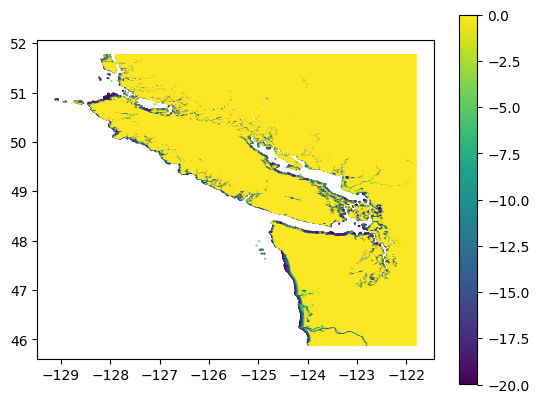

In [13]:
# Plot FILTERED bathymetry from GeoDataFrame
gdf_filtered.plot(
    column="depth", cmap="viridis", legend=True, vmin=MIN_DEPTH, vmax=0, markersize=0.1
)

## Proximity Filtering

While navigating, we will need to take a Lat Lon point and return all the points within a certain radius or bounding rectangle around that point, in the form of Lat Lon points. This can be done with boolean indexing.

In [14]:
sample_point = Point(-122.743184, 48.268958)

### Location of Sample Point
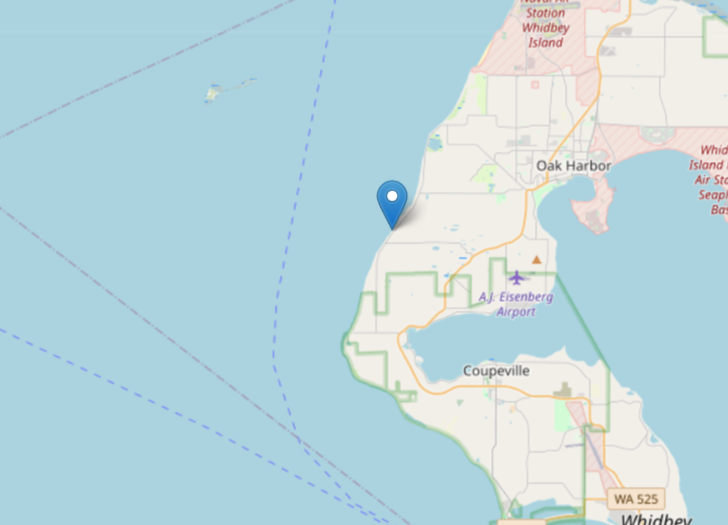

In [15]:
# Load filtered data from NumPy Array into a GeoDataFrame
longitude = dpts_filtered[:, 1]
latitude = dpts_filtered[:, 0]
depth = dpts_filtered[:, 2]

geometry = gpd.points_from_xy(longitude, latitude)

gdf_np_filtered = GeoDataFrame(geometry=geometry, columns=["geometry"])

# Add depth values as a new column
gdf_np_filtered["depth"] = depth

In [16]:
# This constant determines how close points need to be to be considered "nearby"
PROXIMITY_BUFFER = 0.5  # degrees


def nearby_pts(point: Point, gdf: GeoDataFrame, radius: float = PROXIMITY_BUFFER) -> GeoDataFrame:

    buffer_zone = point.buffer(radius)

    # return all points within buffer zone
    spatial_index = gdf.sindex
    possible_matches_index = list(spatial_index.intersection(buffer_zone.bounds))
    possible_matches = gdf.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(buffer_zone)]

    return precise_matches
    return gdf[gdf.geometry.within(buffer_zone)]  # possibly slower method

This appears to be working well.

26428


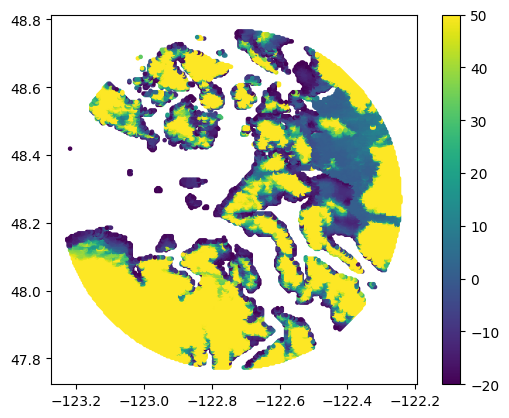

In [17]:
# GEO -> GEO
gdf_near = nearby_pts(point=sample_point, gdf=gdf_filtered)

# Plot all available points within a radius of sample_point
gdf_near.plot(column="depth", cmap="viridis", legend=True, vmin=MIN_DEPTH, vmax=50, markersize=5)

print(len(gdf_near.geometry))

26428


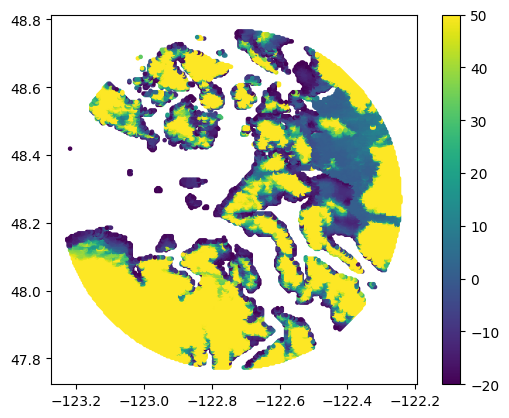

In [18]:
# NUMPY -> GEO
gdf_near = nearby_pts(point=sample_point, gdf=gdf_np_filtered)

# Plot all available points within a radius of sample_point
gdf_near.plot(column="depth", cmap="viridis", legend=True, vmin=MIN_DEPTH, vmax=50, markersize=5)

print(len(gdf_near.geometry))

## Generate Polygons

The next step in the pipeline is to generate polygons from the filtered, nearby points. This is done in two steps:

1. First clustering points into groups using DBSCAN
2. Then we generate alpha shapes out of the clustered points using the alphashape library

TODO: Consider clustering all filtered points from entire data set at once. This ensures the DBSCAN algorithm is only run a maximum of twice on the entire data set.

### Step 1. Clustering

#### Some Helper Functions for Resolving Unclustered Points (red diamond in the diagram)

In [19]:
def box_fix(gdf: GeoDataFrame) -> GeoDataFrame:
    """
    Constructs a box around any Point in gdf for which the entry in the 'cluster' column is -1
    The idea is to add more points around any lone or double points so that DBSCAN can succussfully add that point to a cluster
    which can be then converted into a Polygon.

    Args:
        - gdf (GeoDataFrame): A GeoDataFrame with the columns: 'geometry' (Points), 'elevation', and 'cluster'

    Returns:
        - gdf_copy (GeoDataFrame): A copy of the original data frame with extra points added around any unclustered points and the 'cluster' column removed.
          gdf_copy is ready for the second pass with DBSCAN.
    """
    gdf_copy = gdf.copy()

    # remove the cluster column as it will be added again on the second pass with DBSCAN
    gdf_copy.drop(columns=["cluster"], inplace=True)

    # Extract only the points which were not clustered by DBSCAN
    unclustered_points = gdf[gdf["cluster"] == -1]

    lats = []
    lons = []

    for index, row in unclustered_points.iterrows():

        # Create a box around each unclustered point
        box_points = box_pts(row.geometry)

        lats.extend([point[1] for point in box_points])
        lons.extend([point[0] for point in box_points])

    # add dummy depths for new points since gdf should be depth filtered by the time this function is called
    depths = np.zeros(len(lats))

    geometry = gpd.points_from_xy(lons, lats)

    gdf_tail = GeoDataFrame(geometry=geometry, columns=["geometry"])

    gdf_tail["depth"] = depths

    return pd.concat([gdf_copy, gdf_tail], ignore_index=True)


def box_pts(pt: Point, w: float = 0.001) -> List[Point]:
    """
    Returns a list of points which form a box around the point pt.

    Args:
        - pt (Point): A point around which to build a box of points.
        - w (float): Width of the box

    Returns:
        - points (List[Point]): A list of the points which form a box around the point pt.
    """

    box = pt.buffer(w, cap_style=3)

    return box.exterior.coords

Some points were not clustered. Running DBSCAN again...


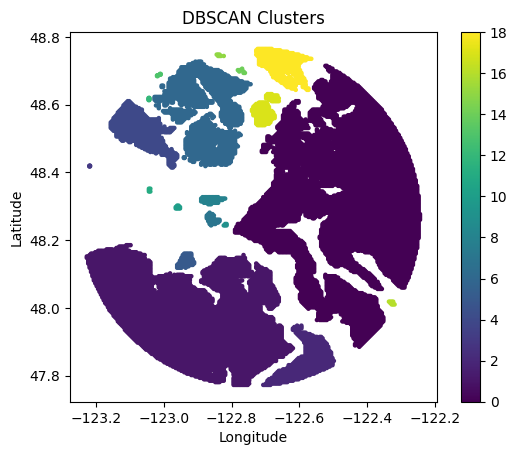

In [20]:
# Redefinition of gdf_near
gdf_near = nearby_pts(point=sample_point, gdf=gdf_filtered)

# ----- FIRST DBSCAN PASS -------
coordinates = MultiPoint([point for point in gdf_near["geometry"]])
coordinates = np.array([(point.x, point.y) for point in gdf_near["geometry"]])

# scale the coordinates
scaler = StandardScaler()
scaled_coordinates = scaler.fit_transform(coordinates)

# perform DBSCAN clustering
# DBSCAN will lable any point which could not be clustered as -1
# with min samples set to 3 any lone or double point clusters will be labeled as -1
# min_samples MUST be at least 3 otherwise we will have clusters with only 1 or 2 points which cannot be converted to polygons
db = DBSCAN(eps=0.001, min_samples=3, metric="haversine").fit(np.radians(scaled_coordinates))

# Add cluster labels to the GeoDataFrame
gdf_near["cluster"] = (
    db.labels_
)  # this modifies a slice of the original dataframe, ignore the warning

# After labeling of points, we want to check which points were not clustered
# and add surrounding points to form a clusterable group
# then we will run the clustering algorithm again

# check if any points were not clustered
if -1 in db.labels_:
    # ---- SECOND DBSCAN PASS ----
    print("Some points were not clustered. Running DBSCAN again...")
    gdf_near = box_fix(gdf_near)
    coordinates = MultiPoint([point for point in gdf_near["geometry"]])
    coordinates = np.array([(point.x, point.y) for point in gdf_near["geometry"]])
    scaled_coordinates = scaler.fit_transform(coordinates)
    db = DBSCAN(eps=0.001, min_samples=3, metric="haversine").fit(np.radians(scaled_coordinates))
    gdf_near["cluster"] = db.labels_


## Plot the clusters
gdf_near.plot(column="cluster", cmap="viridis", legend=True, markersize=5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN Clusters")
plt.show()

# divide up the clusters into separate GeoDataFrames
gdf_clusters = [gdf_near[gdf_near["cluster"] == i] for i in range(max(gdf_near["cluster"]) + 1)]

### Step 2. Generate Alpha Shapes

The parameter alpha has a large effect on the shape of the alphashape. A high value for alpha will give a more concave shape, while a low value will give a more convex shape.

for example, using alpha = 1.0 will yield similar results to returning the convex_hull of each MultiPoint.

To avoid losing polygons or having overlapping polygons, and to preserve finer coastline details, we will use a high value for alpha.

My main concern with this function is losing land mass geometry through this process, and failing to avoid an obstacle as a result.
More research needs to be done to assure this wont happen.

#### alpha = 50

In this case an alpha value of 50 too low as we lost some land masses in the creation of the alphashapes.

In [21]:
# convert each alphashape cluster to a polygon
gdf_polygons = [
    alphashape.alphashape(points=[(point.x, point.y) for point in cluster["geometry"]], alpha=50)
    for cluster in gdf_clusters
]

# plot the polygons using plotly
fig = go.Figure()
trace = 0
for item in gdf_polygons:

    if isinstance(item, MultiPolygon):

        print("Multipolygon found")
        print(item)
        polygons = list(item.geoms)
        for polygon in polygons:

            if polygon.exterior.coords is None:
                print("Lost a polygon, alpha too high")

            x, y = np.array(polygon.exterior.coords.xy)
            x = np.array(x)
            y = np.array(y)
            fig.add_trace(go.Scatter(x=x, y=y, fill="toself", name="cluster polygon"))
            trace += 1
        continue
    if isinstance(item, GeometryCollection):
        print(item)
        continue
    if item.exterior.coords is None:
        print("Lost a polygon, alpha too high")
        continue

    # It is a polygon with points
    x, y = np.array(item.exterior.coords.xy)
    x = np.array(x)
    y = np.array(y)
    fig.add_trace(go.Scatter(x=x, y=y, fill="toself", name="cluster polygon"))
    trace += 1

print("number of traces: ", trace)
fig.show()

Multipolygon found
MULTIPOLYGON (((-122.38541666666666 47.92291666666665, -122.38125 47.92708333333334, -122.37708333333333 47.931250000000006, -122.38541666666666 47.92291666666665)), ((-122.37291666666667 47.93541666666667, -122.36875 47.93958333333333, -122.38541666666666 47.92291666666665, -122.37291666666667 47.93541666666667)), ((-122.45625000000001 48.068749999999994, -122.46458333333334 48.07291666666666, -122.46875 48.07708333333332, -122.47708333333333 48.08125000000001, -122.48541666666667 48.08958333333334, -122.46458333333334 48.12291666666667, -122.45625000000001 48.118750000000006, -122.44791666666666 48.11041666666665, -122.43958333333333 48.10624999999999, -122.43541666666667 48.10624999999999, -122.42291666666667 48.102083333333326, -122.41875 48.09791666666666, -122.41458333333333 48.09375, -122.41041666666666 48.08958333333334, -122.40208333333334 48.085416666666674, -122.39791666666667 48.08125000000001, -122.39375000000001 48.07708333333332, -122.38958333333333 48

#### alpha = 100

In [22]:
# convert each alphashape cluster to a polygon
gdf_polygons = [
    alphashape.alphashape(points=[(point.x, point.y) for point in cluster["geometry"]], alpha=100)
    for cluster in gdf_clusters
]
trace = 0
# plot the polygons using plotly
fig = go.Figure()
for polygon in gdf_polygons:
    if polygon.exterior.coords is None:
        print("Lost a polygon")
    x, y = np.array(polygon.exterior.coords.xy)
    x = np.array(x)
    y = np.array(y)
    fig.add_trace(go.Scatter(x=x, y=y, fill="toself", name="cluster polygon"))
    trace += 1

print("number of traces: ", trace)
fig.show()

number of traces:  19


From here the polygons can be used to create Land obstacles

### Next Steps

Optimize optimize optimize. Also need to test how everything works with larger data sets.